# Question 1.2

### Generate 5 synthetic datasets

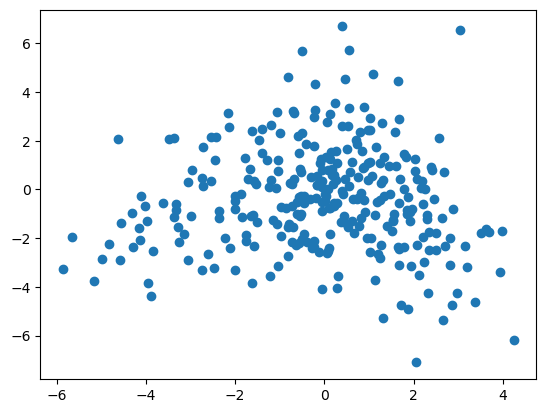

In [1]:
import numpy as np
import matplotlib.pyplot as plt

true_means = np.array([[-1,-1],[1,-1],[0,1]])
params = {
    'Pa': {'mean': np.array([-1, -1]), 'cov': np.array([[2, 0.5], [0.5, 1]])},
    'Pb': {'mean': np.array([1, -1]), 'cov': np.array([[1, -0.5], [-0.5, 2]])},
    'Pc': {'mean': np.array([0, 1]), 'cov': np.array([[1, 0], [0, 2]])}
}

# Sigma values
sigma_values = [0.5, 1, 2, 4, 8]

def generate_datasets(sigma_values, params, n_samples=100):
    datasets = {}
    for sigma in sigma_values:
        datasets[sigma] = np.vstack([
            np.random.multivariate_normal(params['Pa']['mean'], sigma * params['Pa']['cov'], n_samples),
            np.random.multivariate_normal(params['Pb']['mean'], sigma * params['Pb']['cov'], n_samples),
            np.random.multivariate_normal(params['Pc']['mean'], sigma * params['Pc']['cov'], n_samples)
        ])
    return datasets

datasets = generate_datasets(sigma_values, params, n_samples=100)

datasets[sigma_values[0]].shape
plt.scatter(datasets[sigma_values[2]][:,0], datasets[sigma_values[2]][:,1])

### Implement K-Means from scratch

Test on a sample dataset

In [2]:
class KMeans:
    def __init__(self, n_clusters=3, n_init=10, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.inertia_ = float('inf')
        self.best_labels = None

    def fit(self, X):
        for _ in range(self.n_init):
            centroids = self._initialize_centroids(X)

            for _ in range(self.max_iter):
                labels = self._assign_clusters(X, centroids)

                new_centroids = self._update_centroids(X, labels)

                if self._converged(centroids, new_centroids):
                    break

                centroids = new_centroids

            inertia = self._compute_inertia(X, centroids, labels)

            if inertia < self.inertia_:
                self.inertia_ = inertia
                self.centroids = centroids
                self.best_labels = labels

        return self

    def _initialize_centroids(self, X):
        centroids = [X[np.random.choice(range(X.shape[0]))]]
        for _ in range(1, self.n_clusters):
            dist_sq = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            i = np.where(cumulative_probs >= r)[0][0]
            centroids.append(X[i])
        return np.array(centroids)

    def _assign_clusters(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        return np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

    def _converged(self, centroids, new_centroids):
        return np.linalg.norm(centroids - new_centroids, axis=None) < self.tol

    def _compute_inertia(self, X, centroids, labels):
        distances = np.sqrt(((X - centroids[labels])**2).sum(axis=1))
        return np.sum(distances ** 2)

X_test = datasets[sigma_values[0]]
kmeans_scratch = KMeans(n_clusters=3, n_init=10).fit(X_test)

print("The Centroids of the clusters:\n", kmeans_scratch.centroids)
print("The KMeans inertia is:", kmeans_scratch.inertia_)
# kmeans_scratch.centroids, kmeans_scratch.inertia_


The Centroids of the clusters:
 [[ 0.17288781  1.06013924]
 [-1.13258798 -1.12658021]
 [ 0.99832531 -1.2061624 ]]
The KMeans inertia is: 280.3250542879363


### Expectation maximum Algo for GMMs

Test on a sample dataset

In [3]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components=3, n_init=10, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None
        self.converged = False
        self.lower_bound_ = -np.inf
        self.n_features = None

    def fit(self, X):
        self.n_features = X.shape[1]
        for _ in range(self.n_init):
            self._initialize_parameters(X)

            log_likelihood_old = -np.inf
            for _ in range(self.max_iter):
                responsibilities = self._e_step(X)
                self._m_step(X, responsibilities)
                log_likelihood_new = self._compute_log_likelihood(X)

                if log_likelihood_new - log_likelihood_old < self.tol:
                    self.converged = True
                    break
                
                log_likelihood_old = log_likelihood_new

            if log_likelihood_new > self.lower_bound_:
                self.lower_bound_ = log_likelihood_new

        return self

    def _initialize_parameters(self, X):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        self.covariances = np.repeat(np.expand_dims(np.cov(X, rowvar=False), axis=0), self.n_components, axis=0)

        self.weights = np.ones(self.n_components) / self.n_components

    def _e_step(self, X):
        resp = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
        resp /= resp.sum(axis=1)[:, np.newaxis]
        return resp

    def _m_step(self, X, resp):
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        self.means = np.dot(resp.T, X) / nk[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
            self.covariances[k].flat[::self.n_features + 1] += 1e-6  # Add a small value to the diagonal for stability
        self.weights = nk / nk.sum()

    def _compute_log_likelihood(self, X):
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += np.sum(np.log(multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])) * self.weights[k])
        return log_likelihood

gmm_scratch = GMM(n_components=3, n_init=10).fit(X_test)

print("The Centroids of the clusters:\n", gmm_scratch.means)
print("The Lower bound is:", gmm_scratch.lower_bound_)
# gmm_scratch.means, gmm_scratch.lower_bound_


The Centroids of the clusters:
 [[-0.63183674 -0.93220177]
 [ 0.30241429  0.70002251]
 [ 0.36107016 -1.20905433]]
The Lower bound is: -1024.5277327988247


### Test on the different datasets

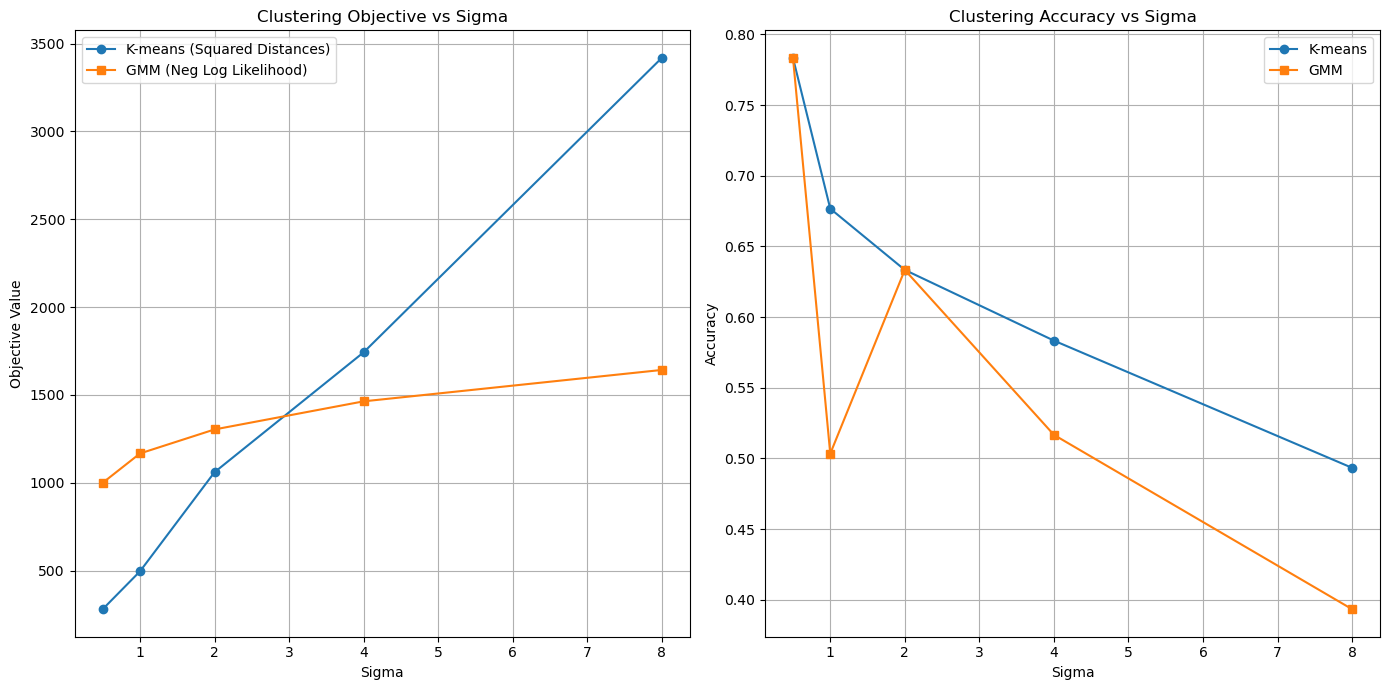

In [4]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def compute_accuracy(labels, centers, true_means):
    mapping = {}
    for i, center in enumerate(centers):
        distances = np.linalg.norm(true_means - center, axis=1)
        mapping[i] = np.argmin(distances)

    predicted_labels = np.vectorize(mapping.get)(labels)
    
    true_labels = np.repeat(np.arange(len(true_means)), len(labels) // len(true_means))


    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy


kmeans_accuracies_scratch = []
gmm_accuracies_scratch = []
kmeans_objectives_scratch = []
gmm_objectives_scratch = []


k = 3
n_it = 10
for sigma, dataset in datasets.items():
    # K-means
    kmeans_model = KMeans(n_clusters=k, n_init=n_it).fit(dataset)
    kmeans_accuracy = compute_accuracy(kmeans_model.best_labels, kmeans_model.centroids, true_means)
    kmeans_accuracies_scratch.append(kmeans_accuracy)
    kmeans_objectives_scratch.append(kmeans_model.inertia_)

    # GMM
    gmm_model = GMM(n_components=k, n_init=n_it).fit(dataset)
    gmm_labels = np.argmax(gmm_model._e_step(dataset), axis=1)  # Labels
    gmm_accuracy = compute_accuracy(gmm_labels, gmm_model.means, true_means)
    gmm_accuracies_scratch.append(gmm_accuracy)
    gmm_objectives_scratch.append(-gmm_model.lower_bound_)  # Negative log-likelihood

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(sigma_values, kmeans_objectives_scratch, marker='o', label='K-means (Squared Distances)')
plt.plot(sigma_values, gmm_objectives_scratch, marker='s', label='GMM (Neg Log Likelihood)')
plt.title('Clustering Objective vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Objective Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sigma_values, kmeans_accuracies_scratch, marker='o', label='K-means')
plt.plot(sigma_values, gmm_accuracies_scratch, marker='s', label='GMM')
plt.title('Clustering Accuracy vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Question 2

### Load datasets

In [5]:
import pandas as pd

# Load the 2D dataset
data2D_path = './data/data/data2D.csv'
data2D = pd.read_csv(data2D_path, header=None) 

# Load the 1000D dataset
data1000D_path = './data/data/data1000D.csv'
data1000D = pd.read_csv(data1000D_path, header=None)

data1000D_shape = data1000D.shape
data1000D_head = data1000D.head()




### Implement the three PCAs

In [6]:
import numpy as np

def buggy_pca(X, d):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    # Take the top d components
    Z = np.dot(U[:,:d], np.diag(S[:d]))
    X_reconstructed = np.dot(Z, Vt[:d,:])
    return Z, (U, S, Vt), X_reconstructed

def demeaned_pca(X, d):
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    Z = np.dot(X_demeaned, Vt[:d].T)
    X_reconstructed = np.dot(Z, Vt[:d]) + mean_X
    return Z, (U, S, Vt, mean_X), X_reconstructed

def normalized_pca(X, d):
    # Subtract the mean and divide by the standard deviation
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    U, S, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    # Take the top d components
    Z = np.dot(X_normalized, Vt[:d].T)
    X_reconstructed = (np.dot(Z, Vt[:d]) * std_X) + mean_X
    return Z, (U, S, Vt, mean_X, std_X), X_reconstructed

def dro(X, d):
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    Z = np.dot(X_demeaned, Vt[:d].T)
    # Reconstruction using the estimated parameters A and b
    X_reconstructed = np.dot(Z, Vt[:d]) + mean_X
    return Z, (U, S, Vt, mean_X), X_reconstructed


# (Z_buggy, X_recon_buggy, error_buggy), (Z_demeaned, X_recon_demeaned, error_demeaned), (Z_normalized, X_recon_normalized, error_normalized), (Z_dro, X_recon_dro, error_dro)


### Define Reconstruction error

In [7]:
def reconstruction_error(X, X_reconstructed):
    return np.sum(np.linalg.norm(X - X_reconstructed, 1, axis=1)**2)/ 100

### Find PCAs for 'data2D.csv'

In [13]:
X_example = np.array(data2D)
d = 1
Z_buggy, params_buggy, X_recon_buggy = buggy_pca(X_example, d)
Z_demeaned, params_demeaned, X_recon_demeaned = demeaned_pca(X_example, d)
Z_normalized, params_normalized, X_recon_normalized = normalized_pca(X_example, d)
Z_dro, params_dro, X_recon_dro = dro(X_example, d)

# Calculate the reconstruction error for the example
error_buggy = reconstruction_error(X_example, X_recon_buggy)
error_demeaned = reconstruction_error(X_example, X_recon_demeaned)
error_normalized = reconstruction_error(X_example, X_recon_normalized)
error_dro = reconstruction_error(X_example, X_recon_dro)

print("Error for Buggy PCA:", error_buggy)
print("Error for Demeaned PCA:", error_demeaned)
print("Error for Normalized PCA:", error_normalized)
print("Error for DRO:", error_dro)

Error for Buggy PCA: 0.884691951047077
Error for Demeaned PCA: 0.007149309154951905
Error for Normalized PCA: 0.03603156595649728
Error for DRO: 0.007149309154951905


### Visualize the Singular values of SVD of 'data1000D' to identify a "knee point"

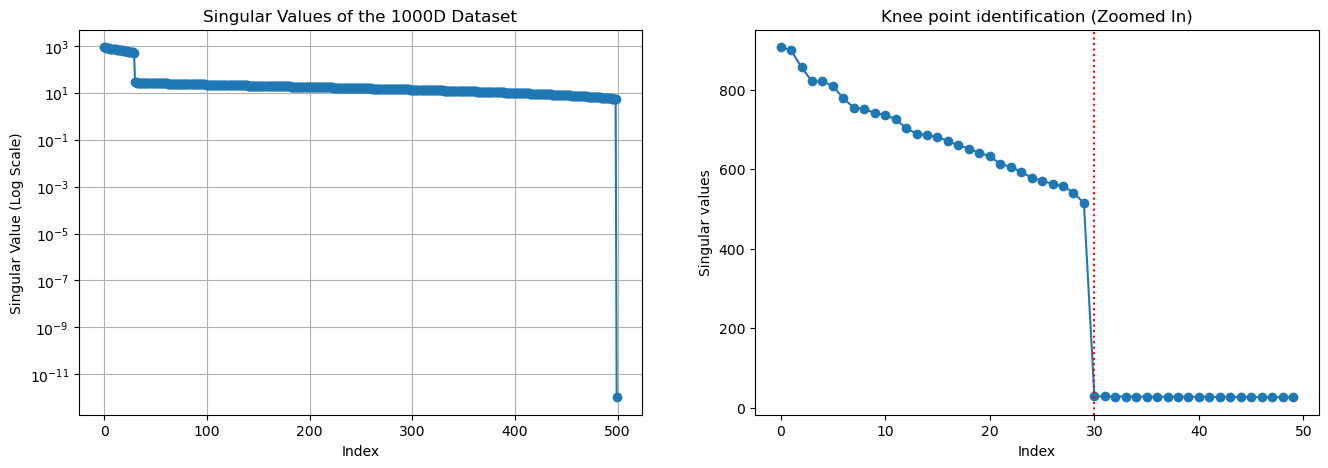

In [14]:
_, (U, S, Vt, mean_X), _ = demeaned_pca(data1000D.values, min(data1000D.shape))

# Plot the singular values to find the "knee point"
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(S, 'o-')
plt.title('Singular Values of the 1000D Dataset')
plt.xlabel('Index')
plt.ylabel('Singular Value (Log Scale)')
plt.yscale('log')  # Use logarithmic scale to better visualize the "knee point"
plt.grid(True)

plt.subplot(122)
plt.plot(S[:50], 'o-')
plt.axvline(x = 30,color = 'r', linestyle=':',label = 'axvline - full height')
plt.title("Knee point identification (Zoomed In)")
plt.ylabel("Singular values")
plt.xlabel("Index")

plt.show()


#### Zoom in on the first part of the plot to get the knee point

Text(0.5, 0, 'Index')

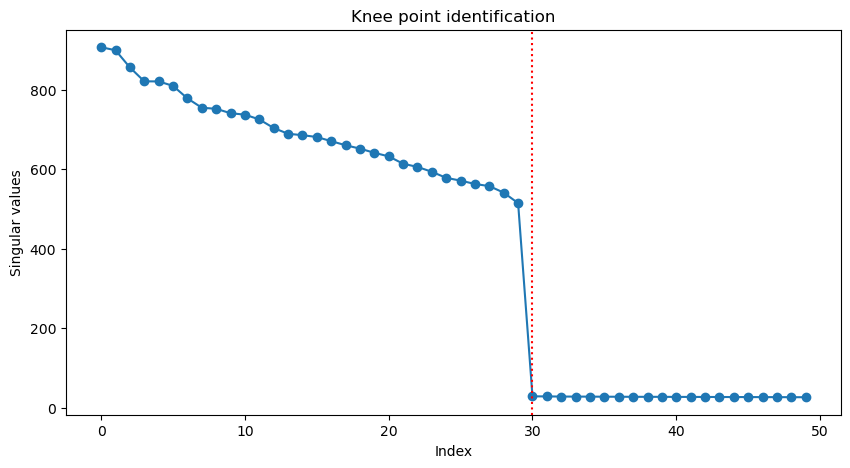

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(S[:50], 'o-')
plt.axvline(x = 30,color = 'r', linestyle=':',label = 'axvline - full height')
plt.title("Knee point identification")
plt.ylabel("Singular values")
plt.xlabel("Index")

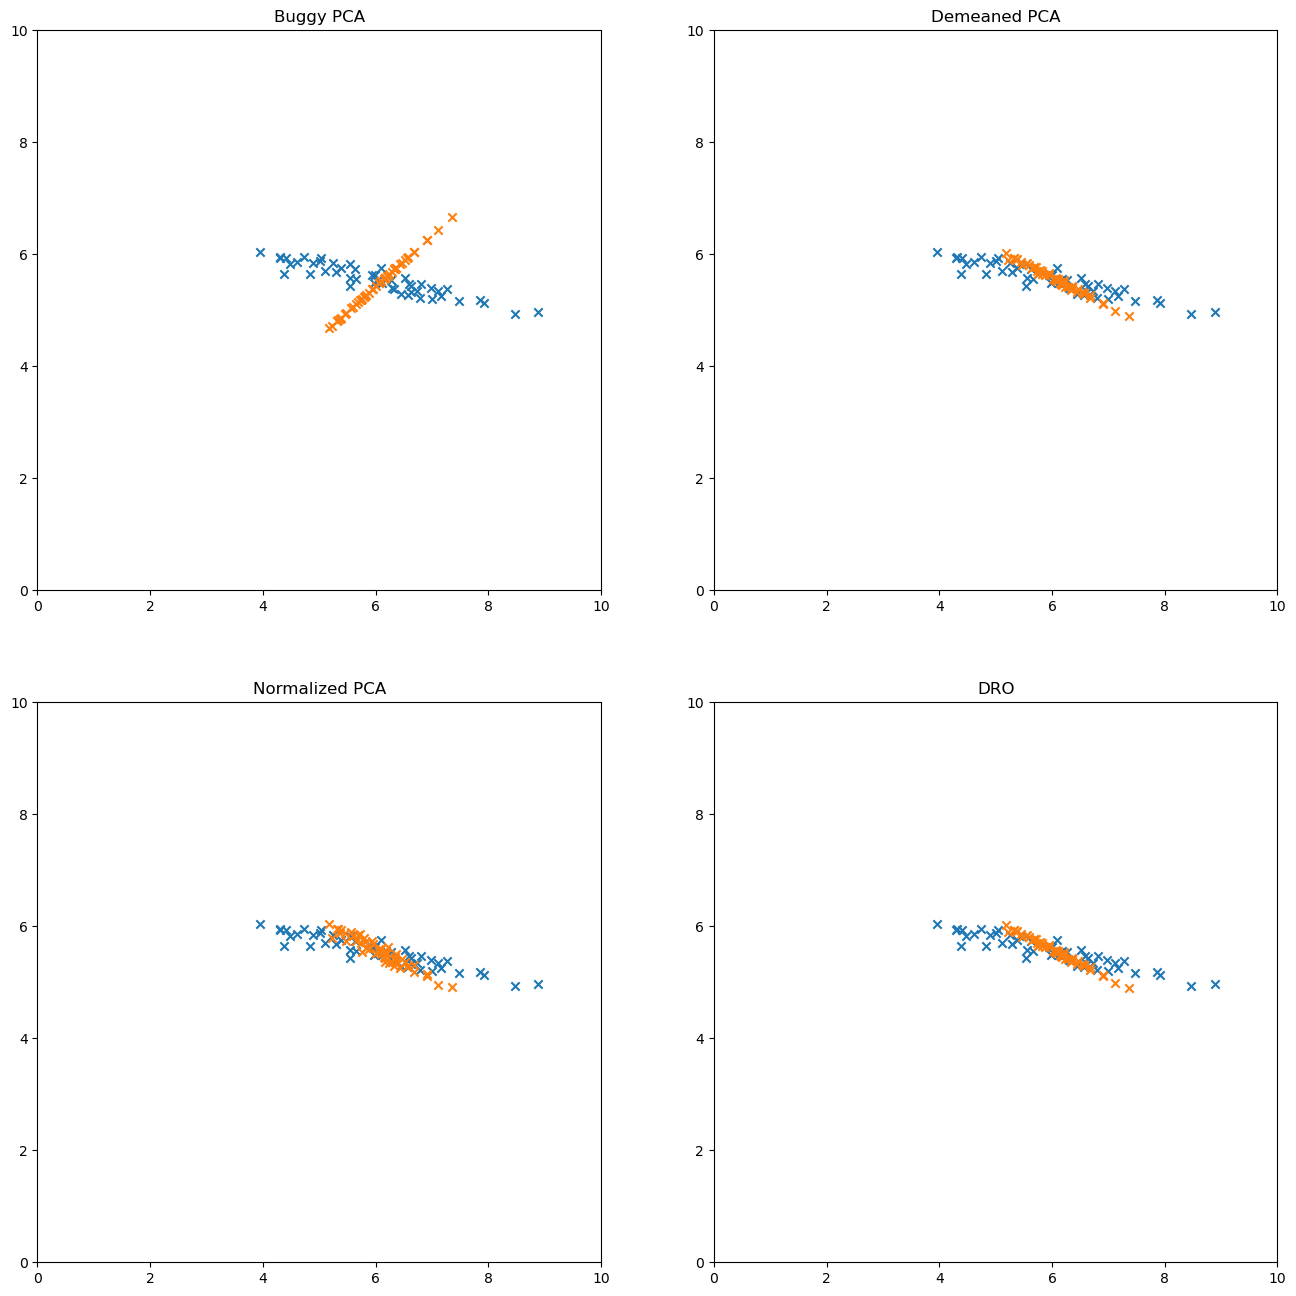

In [16]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(18,32))
fig, axs = plt.subplots(2, 2)
fig.set_figheight(16)
fig.set_figwidth(16)
axs[0,0].scatter(np.array(data2D)[:,0], np.array(data2D)[:, 1], marker='x')
axs[0,0].scatter(X_recon_buggy[:, 0], X_recon_buggy[:, 1], marker='x')
axs[0,0].set_title("Buggy PCA")
axs[0,0].set_xlim([0,10])
axs[0,0].set_ylim([0,10])
# axs[0,0].set_marker('.')

axs[0,1].scatter(np.array(data2D)[:,0], np.array(data2D)[:, 1], marker='x')
axs[0,1].scatter(X_recon_buggy[:, 0], X_recon_demeaned[:, 1], marker='x')
axs[0,1].set_title("Demeaned PCA")
axs[0,1].set_xlim([0,10])
axs[0,1].set_ylim([0,10])

axs[1,0].scatter(np.array(data2D)[:,0], np.array(data2D)[:, 1], marker='x')
axs[1,0].scatter(X_recon_buggy[:, 0], X_recon_normalized[:, 1], marker='x')
axs[1,0].set_title("Normalized PCA")
axs[1,0].set_xlim([0,10])
axs[1,0].set_ylim([0,10])

axs[1,1].scatter(np.array(data2D)[:,0], np.array(data2D)[:, 1], marker='x')
axs[1,1].scatter(X_recon_buggy[:, 0], X_recon_dro[:, 1], marker='x')
axs[1,1].set_title("DRO")
axs[1,1].set_xlim([0,10])
axs[1,1].set_ylim([0,10])

plt.show()